[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yueliyl/comp551-notebooks/blob/master/MulticlassLogistic.ipynb)

# Multiclass Regression

In [6]:
import numpy as np
from sklearn import model_selection
from matplotlib import pyplot as plt
from sklearn import preprocessing
import random
random.seed(551)

# Simulate toy data

In [7]:
N = 150

X = np.column_stack((np.random.binomial(1, 0.5, N),
                     np.random.binomial(1, 0.5, N),
                     np.random.binomial(1, 0.5, N),
                     np.random.binomial(1, 0.5, N)))

W_true = np.array([[0,1,0],
                   [0,0,1],
                   [1,0,0],
                   [0,0,1]])

a = np.matmul(X, W_true)
y = np.zeros_like(a)
y[np.arange(len(a)), a.argmax(1)] = 1

In [8]:
class Multinomial_logistic:
    def __init__(self, nFeatures, nClasses):
        self.W = np.random.rand(nFeatures, nClasses)

    def predict(self, X):
        y_pred = np.exp(np.matmul(X, self.W))
        return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)

    def grad(self, X, y):
        return np.matmul(X.transpose(), self.predict(X) - y)

    def ce(self, X, y):
        return -np.sum(y * np.log(self.predict(X)))

    # modify it to add stopping criteria (what can you think of?)
    def fit(self, X, y, X_valid=None, y_valid=None, lr=0.005, niter=100):
        losses_train = np.zeros(niter)
        losses_valid = np.zeros(niter)
        for i in range(niter):
            self.W = self.W - lr * self.grad(X, y)
            loss_train = self.ce(X, y)
            losses_train[i] = loss_train
            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)
                losses_valid[i] = loss_valid
                print(f"iter {i}: {loss_train:.3f}; {loss_valid:.3f}")
            else:
                print(f"iter {i}: {loss_train:.3f}")
        return losses_train, losses_valid

    def check_grad(self, X, y):
        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4

                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()

        # print(diff)
        return diff.sum()


Split the data into training, validation, and testing

In [9]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size = 0.33, random_state=1, shuffle=True)

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X_train, y_train, test_size = 0.5, random_state=1, shuffle=True)

Create Multinomial Logistic Regression model object

In [10]:
D = X.shape[1]
C = y.shape[1]

mlr = Multinomial_logistic(D, C)

Check gradients

In [11]:
# check grad
print(mlr.check_grad(X_train, y_train))

4.391228835778034e-16


Fitting the multinomial logistic model

iter 0: 49.092; 53.078
iter 1: 47.081; 50.433
iter 2: 45.303; 48.121
iter 3: 43.724; 46.094
iter 4: 42.318; 44.311
iter 5: 41.059; 42.735
iter 6: 39.925; 41.333
iter 7: 38.897; 40.079
iter 8: 37.960; 38.951
iter 9: 37.101; 37.928
iter 10: 36.309; 36.995
iter 11: 35.574; 36.140
iter 12: 34.890; 35.351
iter 13: 34.249; 34.619
iter 14: 33.647; 33.938
iter 15: 33.079; 33.300
iter 16: 32.541; 32.701
iter 17: 32.030; 32.136
iter 18: 31.544; 31.601
iter 19: 31.080; 31.094
iter 20: 30.637; 30.611
iter 21: 30.212; 30.151
iter 22: 29.804; 29.711
iter 23: 29.412; 29.289
iter 24: 29.035; 28.885
iter 25: 28.672; 28.496
iter 26: 28.321; 28.122
iter 27: 27.982; 27.762
iter 28: 27.655; 27.414
iter 29: 27.338; 27.078
iter 30: 27.032; 26.754
iter 31: 26.735; 26.439
iter 32: 26.447; 26.135
iter 33: 26.168; 25.840
iter 34: 25.897; 25.554
iter 35: 25.633; 25.276
iter 36: 25.378; 25.006
iter 37: 25.129; 24.744
iter 38: 24.887; 24.489
iter 39: 24.652; 24.240
iter 40: 24.423; 23.999
iter 41: 24.199; 23.763
it

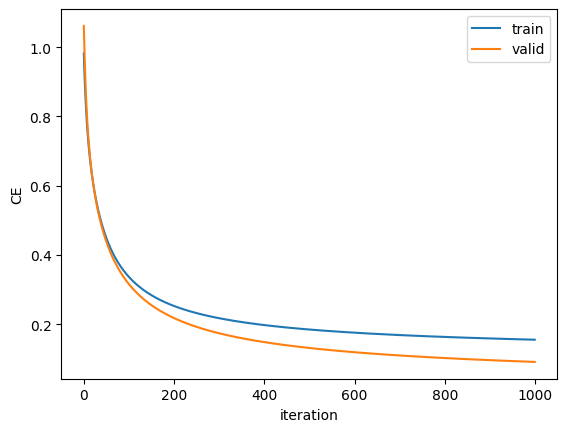

In [12]:
ce_train, ce_valid = mlr.fit(X_train, y_train, X_valid, y_valid, niter=1000)

plt.clf()
plt.plot(ce_train/X_train.shape[0], label='train')
plt.plot(ce_valid/X_valid.shape[0], label='valid')
plt.xlabel("iteration")
plt.ylabel("CE")
plt.legend()
# plt.show()
plt.savefig("training_ce.png", bbox_inches="tight", dpi=300)

#tried running with large niter (100000), and still find that the ultimate iteration has the best fit, Assuming this is because we don't see overfitting happen with our model
#also, this makes sense given that the assignment says we should continue to see a decrease in CE

From the above plot, we can see that the training and validation error curves both continue to decrease. Therefore, there is no sign of overfitting.

In [13]:
def evaluate(y, y_pred):
    accuracy = sum(y_pred.argmax(axis=1) == y.argmax(axis=1))
    accuracy = accuracy / y.shape[0]
    return accuracy

In [14]:
train_accuracy = evaluate(mlr.predict(X_train), y_train)
valid_accuracy = evaluate(mlr.predict(X_valid), y_valid)
test_accuracy = evaluate(mlr.predict(X_test), y_test)

print(train_accuracy)
print(valid_accuracy)
print(test_accuracy)

1.0
1.0
1.0


In [15]:
print(mlr.W)
print(W_true)

[[-0.42056964  3.80408928 -2.5337081 ]
 [-1.36779192 -0.24500384  3.20827387]
 [ 5.93525856 -2.94590244 -0.87533247]
 [-1.23688431 -0.84102375  3.7943371 ]]
[[0 1 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]]


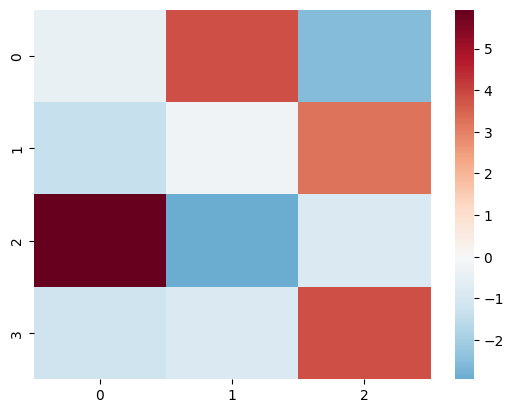

In [16]:
from seaborn import heatmap
W_hat = mlr.W
hmp = heatmap(W_hat, cmap='RdBu_r', center=0)
fig = hmp.get_figure()
fig.savefig("W_hat.png")

Plot as softmax

In [17]:
W_hat_transformed = np.exp(W_hat)
W_hat_transformed = W_hat_transformed / W_hat_transformed.sum(axis=0)[None,:]
W_hat_transformed

array([[1.73109536e-03, 9.72556862e-01, 1.13896120e-03],
       [6.71347819e-04, 1.69596234e-02, 3.54993186e-01],
       [9.96832313e-01, 1.13875644e-03, 5.98042869e-03],
       [7.65244181e-04, 9.34475771e-03, 6.37887424e-01]])

Now plot the softmax-transformed heatmap, which looks almost identical to groundtruth.

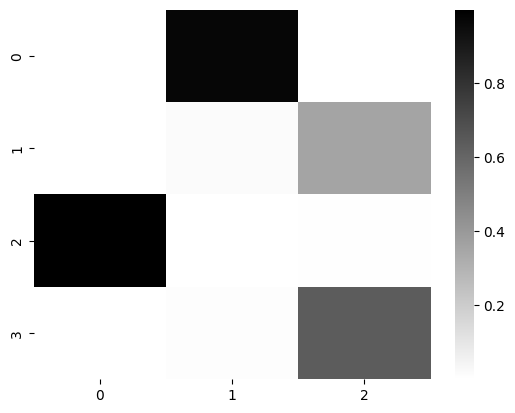

In [18]:
hmp = heatmap(W_hat_transformed, cmap='gray_r')
fig = hmp.get_figure()
fig.savefig("W_hat_transformed.png")

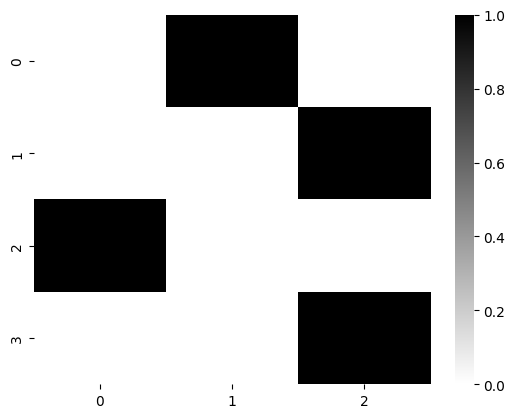

In [19]:
hmp = heatmap(W_true, cmap='gray_r')
fig = hmp.get_figure()
fig.savefig("W_true.png")

# Iris flower classification

In [20]:
from sklearn import datasets

# import some data to play with
iris = datasets.load_iris()

print(iris['target_names']) # print flower types
print(iris['feature_names']) # print flower feature names

X = iris.data
y_cat = iris.target
print("test")
print(y_cat)

# convert array of class indices to one-hot encoded array
y = np.zeros((y_cat.size, y_cat.max() + 1))
y[np.arange(y_cat.size), y_cat] = 1

print(y)

['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
test
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0

Once again, we split the data into training, testing, and validation

In [21]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size = 0.33, random_state=1, shuffle=True)

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X_train, y_train, test_size = 0.5, random_state=1, shuffle=True)

N, C = y_train.shape

X_train = preprocessing.scale(X_train) # standardize input data
X_train = np.c_[X_train, np.ones(N)] # add one column to learn the linear intercept
X_valid = preprocessing.scale(X_valid)
X_valid = np.c_[X_valid, np.ones(X_valid.shape[0])]
X_test = preprocessing.scale(X_test)
X_test = np.c_[X_test, np.ones(X_test.shape[0])]

D = X_train.shape[1]

In [22]:
mlr = Multinomial_logistic(D, C)

# check grad
print(mlr.check_grad(X_train, y_train))

1.3472622314927922e-17


iter 0: 46.089; 45.836
iter 1: 38.250; 38.699
iter 2: 33.360; 34.413
iter 3: 30.115; 31.678
iter 4: 27.834; 29.819
iter 5: 26.147; 28.479
iter 6: 24.846; 27.463
iter 7: 23.806; 26.658
iter 8: 22.950; 25.996
iter 9: 22.230; 25.437
iter 10: 21.610; 24.952
iter 11: 21.069; 24.525
iter 12: 20.590; 24.141
iter 13: 20.160; 23.793
iter 14: 19.771; 23.473
iter 15: 19.416; 23.177
iter 16: 19.089; 22.902
iter 17: 18.786; 22.644
iter 18: 18.504; 22.401
iter 19: 18.240; 22.171
iter 20: 17.992; 21.953
iter 21: 17.758; 21.746
iter 22: 17.536; 21.548
iter 23: 17.325; 21.359
iter 24: 17.124; 21.178
iter 25: 16.932; 21.005
iter 26: 16.748; 20.838
iter 27: 16.571; 20.677
iter 28: 16.401; 20.521
iter 29: 16.238; 20.372
iter 30: 16.080; 20.227
iter 31: 15.927; 20.086
iter 32: 15.779; 19.951
iter 33: 15.636; 19.819
iter 34: 15.497; 19.691
iter 35: 15.362; 19.567
iter 36: 15.230; 19.446
iter 37: 15.102; 19.328
iter 38: 14.977; 19.213
iter 39: 14.856; 19.102
iter 40: 14.737; 18.993
iter 41: 14.621; 18.887
it

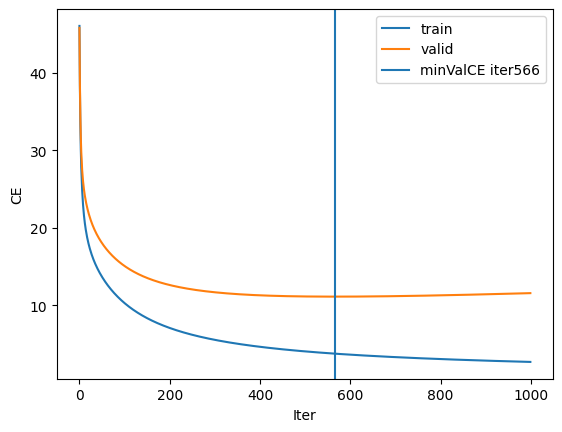

In [23]:
ce_train, ce_valid = mlr.fit(X_train, y_train, X_valid, y_valid, niter=1000)
optimal_niter = ce_valid.argmin()

plt.plot(ce_train, label='train')
plt.plot(ce_valid, label='valid')
plt.axvline(x=optimal_niter, label=f"minValCE iter{optimal_niter}")
plt.legend()
plt.xlabel("Iter")
plt.ylabel("CE")
plt.savefig("iris_training_ce.png", bbox_inches="tight", dpi=300)

In [24]:
mlr = Multinomial_logistic(D, C)
optimal_niter = ce_valid.argmin()
_, _ = mlr.fit(X_train, y_train, niter=optimal_niter) # retrain the model using best niter

iter 0: 40.025
iter 1: 36.354
iter 2: 33.656
iter 3: 31.550
iter 4: 29.834
iter 5: 28.397
iter 6: 27.168
iter 7: 26.101
iter 8: 25.167
iter 9: 24.340
iter 10: 23.605
iter 11: 22.947
iter 12: 22.354
iter 13: 21.818
iter 14: 21.330
iter 15: 20.885
iter 16: 20.476
iter 17: 20.100
iter 18: 19.751
iter 19: 19.427
iter 20: 19.125
iter 21: 18.842
iter 22: 18.577
iter 23: 18.326
iter 24: 18.090
iter 25: 17.865
iter 26: 17.651
iter 27: 17.448
iter 28: 17.253
iter 29: 17.067
iter 30: 16.888
iter 31: 16.717
iter 32: 16.551
iter 33: 16.391
iter 34: 16.237
iter 35: 16.087
iter 36: 15.942
iter 37: 15.802
iter 38: 15.665
iter 39: 15.532
iter 40: 15.403
iter 41: 15.277
iter 42: 15.154
iter 43: 15.034
iter 44: 14.917
iter 45: 14.802
iter 46: 14.690
iter 47: 14.580
iter 48: 14.472
iter 49: 14.367
iter 50: 14.263
iter 51: 14.162
iter 52: 14.062
iter 53: 13.964
iter 54: 13.868
iter 55: 13.774
iter 56: 13.681
iter 57: 13.589
iter 58: 13.499
iter 59: 13.411
iter 60: 13.324
iter 61: 13.238
iter 62: 13.154
it

Check classification accuracy on training, validation, and testing sets

In [25]:
train_accuracy = evaluate(mlr.predict(X_train), y_train)
valid_accuracy = evaluate(mlr.predict(X_valid), y_valid)
test_accuracy = evaluate(mlr.predict(X_test), y_test)

print(train_accuracy)
print(valid_accuracy)
print(test_accuracy)

0.98
0.9
0.96


Visualize feature weights for each flower class

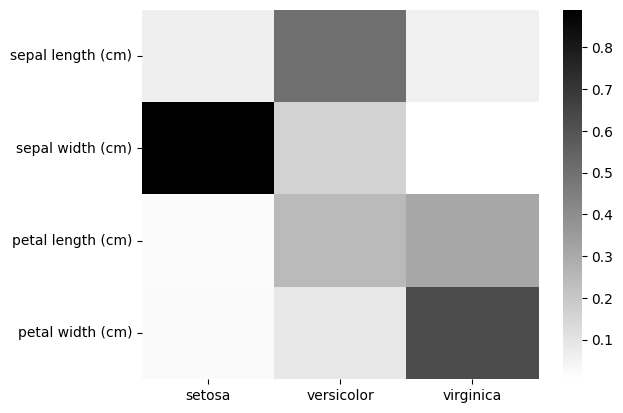

In [26]:
W_hat = mlr.W[:-1,:] # remove the intercept
W_hat_transformed = np.exp(W_hat)
W_hat_transformed = W_hat_transformed / W_hat_transformed.sum(axis=0)[None,:]

import pandas as pd
iris = datasets.load_iris()
feature_names = iris['feature_names'].copy()
label_names = iris['target_names'].tolist()

W_hat_transformed_df = pd.DataFrame(W_hat_transformed, columns=label_names, index=feature_names)
hmp = heatmap(W_hat_transformed_df, cmap='gray_r')
fig = hmp.get_figure()
fig.savefig("iris_W_hat_transformed.png", bbox_inches="tight", dpi=300)